Using the boston house-prices dataset, predict house prices given a set of features. Use pipeline in conjunction with f_regression, StandardScaler, and ElasticNet to find the optimal regression model.

(Created by An for Metis review 2018)

In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

boston = load_boston()
X, y = pd.DataFrame(boston.data), boston.target
X.columns = boston.feature_names
X_data, X_holdout, y_data, y_holdout = train_test_split(X,y, test_size=.3, random_state=3)

In [2]:
# Use pipeline to:
#   1. Standardize features
#   2. Select features of significance using SelectKBest, passing f_regression (ANOVA test)
#   3. Model with ElasticNet

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler    
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet

# Split X_data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=.2, random_state=0)

# Instantiate SelectKBest with f_regression
KBest_filter = SelectKBest(f_regression)

# Notice that instantiated objects passed to pipeline have () at the end,
# whereas variable calls don't because they reference an instantiated
# object already
elastic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('KBest', KBest_filter),
    ('enet', ElasticNet())
])

elastic_pipe.set_params(scaler__with_mean=True,
                        scaler__with_std=True,
                        KBest__k = 10).fit(X_train, y_train)

score = elastic_pipe.score(X_test, y_test)
print('Test set score for non-CV model:', score)

Test set score for non-CV model: 0.7059467726444376


In [3]:
# 4. (Optional) Reinstantiate your pipe, then use GridSearchCV or
# RandomizedGridCV to optimize ElasticNet hyperparams (alpha and l1_ratio)

from sklearn.model_selection import GridSearchCV

# Define the pipeline with an alias for the objects
KBest_filter = SelectKBest(f_regression)
elastic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('KBest', KBest_filter),
    ('enet', ElasticNet())
])

# Set params of objects passed to pipeline
elastic_pipe.set_params(scaler__with_mean=True,
                        scaler__with_std=True)

# Set gridsearch params
params = {'KBest__k': [1, 2, 4, 8, 13],
          'enet__alpha': [0.001, 0.01, 0.1, 1],
          'enet__l1_ratio': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]}

# Pass pipeline and params to GridSearchCV
grid = GridSearchCV(elastic_pipe, params, cv=5, n_jobs=-1, return_train_score=True)
grid.fit(X_data, y_data)
print('Best score for grid:', grid.best_score_)
print('Holdout score:', grid.score(X_holdout, y_holdout))

##############
# Create final elasticmodel
KBest_filter = SelectKBest(f_regression)
final_pipe = elastic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('KBest', KBest_filter),
    ('enet', ElasticNet())
])

final_pipe.set_params(scaler__with_mean=True,
                        scaler__with_std=True,
                        **grid.best_params_)
final_pipe.fit(X_data, y_data)
score = final_pipe.score(X_holdout, y_holdout)
print('Holdout score (double check):', score)

Best score for grid: 0.7072688646506633
Holdout score: 0.7124326534019187
Holdout score (double check): 0.7124326534019187


{'KBest__k': 13, 'enet__alpha': 0.01, 'enet__l1_ratio': 0.1}


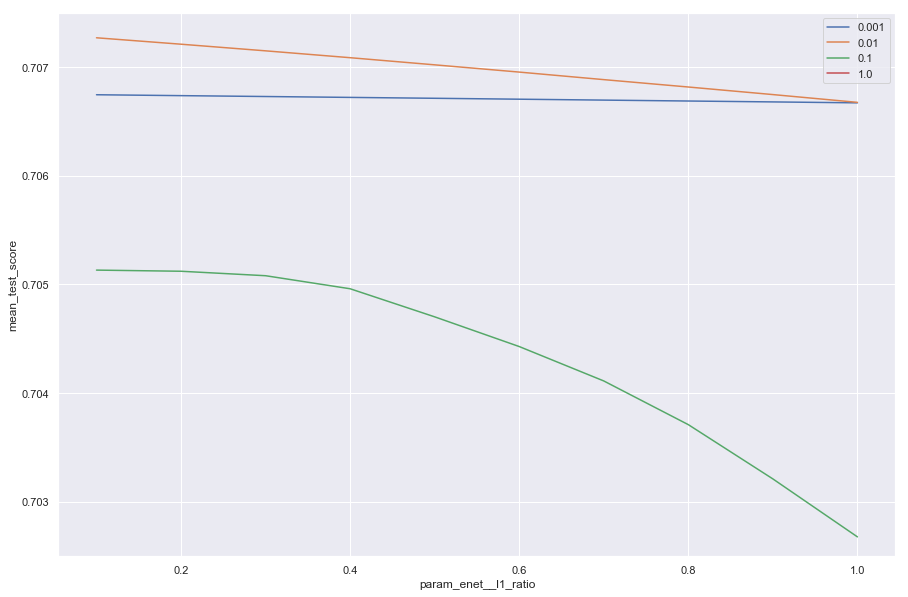

In [6]:
# 5. (Extra sauce) Using all 13 features, plot score on y-axis vs l1_ratio on x-axis, for each value of alpha.

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Select results of interest from grid
results = pd.DataFrame(grid.cv_results_)
results = results[['param_KBest__k', 'param_enet__alpha', 'param_enet__l1_ratio', 'mean_test_score']]

# Groupy alphas
KB_alpha = results.groupby(['param_enet__alpha', 'param_KBest__k'])
for alpha_k, g in KB_alpha:
    a, k = alpha_k[0], alpha_k[1]

# Plot results
f, ax = plt.subplots(figsize=(15,10))

for alpha_k, data in KB_alpha:
    a, k = alpha_k[0], alpha_k[1]
    if k==13:
        sns.lineplot(x = 'param_enet__l1_ratio', y='mean_test_score',
                     data=data, label=a, ci=None)
ax.set_ylim(.7025, .7075)
print(grid.best_params_)